In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from plotnine import (
    ggplot, aes, geom_line, geom_point, facet_grid, stat_summary,
    theme, element_text, theme_bw, geom_boxplot, geom_bar, ylim,
    geom_tile, geom_text
)
from plotnine.scales import scale_y_log10, scale_x_log10, scale_x_discrete, scale_y_reverse, scale_fill_cmap
import os

import torch
import numpy as np
from tqdm import tqdm
import math
import json

DEVICE = "cpu"

In [64]:
datas = []
for layers in [1, 2, 3, 4, 8, 12, 16]:
    data = pd.read_csv(f"logs/{layers}-1,1,1,1,1-1,0,0,0,0/in_context_probs.csv")
    data['shots'] = data['shots'] + 1
    data['layers'] = layers
    datas.append(data)
data = pd.concat(datas)

filter = (data['sft_amount'] == -1)
for sft_amount in data['sft_amount'].unique():
    maxi = data[data['sft_amount'] == sft_amount]['sft'].max()
    filter |= ((data['sft'] == maxi) & (data['sft_amount'] == sft_amount)) 
data = data[filter]
data

,Unnamed: 0,shots,k,hmm,sft,sft_amount,prob,acc,nll,layers
0,0,1,3,0,0,0,0.241505,0.467593,1.687721,1
13,13,1,3,0,60,50,0.352147,0.592593,1.271699,1
21,21,1,3,0,300,250,0.396162,0.648148,1.092497,1
27,27,1,3,0,600,500,0.417783,0.680556,1.019396,1
33,33,1,3,0,1200,1000,0.439053,0.726852,0.946873,1
...,...,...,...,...,...,...,...,...,...,...
135858,135858,256,3,4,300,250,0.143272,0.203488,3.320963,16
135864,135864,256,3,4,600,500,0.108411,0.145349,3.745153,16
135870,135870,256,3,4,1200,1000,0.092595,0.110465,4.472777,16
135875,135875,256,3,4,3000,2500,0.080811,0.093023,5.584808,16


In [65]:
all_df = data
all_df['nll_avg'] = all_df['nll']
all_df['nll'] = all_df['prob'].map(lambda x: -math.log(x))
all_df

,Unnamed: 0,shots,k,hmm,sft,sft_amount,prob,acc,nll,layers,nll_avg
0,0,1,3,0,0,0,0.241505,0.467593,1.420865,1,1.687721
13,13,1,3,0,60,50,0.352147,0.592593,1.043706,1,1.271699
21,21,1,3,0,300,250,0.396162,0.648148,0.925932,1,1.092497
27,27,1,3,0,600,500,0.417783,0.680556,0.872793,1,1.019396
33,33,1,3,0,1200,1000,0.439053,0.726852,0.823134,1,0.946873
...,...,...,...,...,...,...,...,...,...,...,...
135858,135858,256,3,4,300,250,0.143272,0.203488,1.943011,16,3.320963
135864,135864,256,3,4,600,500,0.108411,0.145349,2.221825,16,3.745153
135870,135870,256,3,4,1200,1000,0.092595,0.110465,2.379520,16,4.472777
135875,135875,256,3,4,3000,2500,0.080811,0.093023,2.515637,16,5.584808


In [66]:
df = all_df[all_df["sft_amount"] == 0]
df

,Unnamed: 0,shots,k,hmm,sft,sft_amount,prob,acc,nll,layers,nll_avg
0,0,1,3,0,0,0,0.241505,0.467593,1.420865,1,1.687721
43,43,1,3,1,0,0,0.269561,0.521951,1.310960,1,1.630175
86,86,1,3,2,0,0,0.203513,0.421622,1.592027,1,1.905494
129,129,1,3,3,0,0,0.252439,0.495495,1.376585,1,1.718076
172,172,1,3,4,0,0,0.192388,0.348837,1.648242,1,1.986193
...,...,...,...,...,...,...,...,...,...,...,...
135665,135665,256,3,0,0,0,0.215695,0.393519,1.533891,16,2.692415
135708,135708,256,3,1,0,0,0.477843,0.839024,0.738473,16,1.006980
135751,135751,256,3,2,0,0,0.306572,0.605405,1.182302,16,1.622604
135794,135794,256,3,3,0,0,0.367832,0.509009,1.000128,16,1.607175


/var/folders/ks/tsqyvj_n5bv55g97m0fc7tb40000gn/T/ipykernel_56062/1029300889.py:6: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


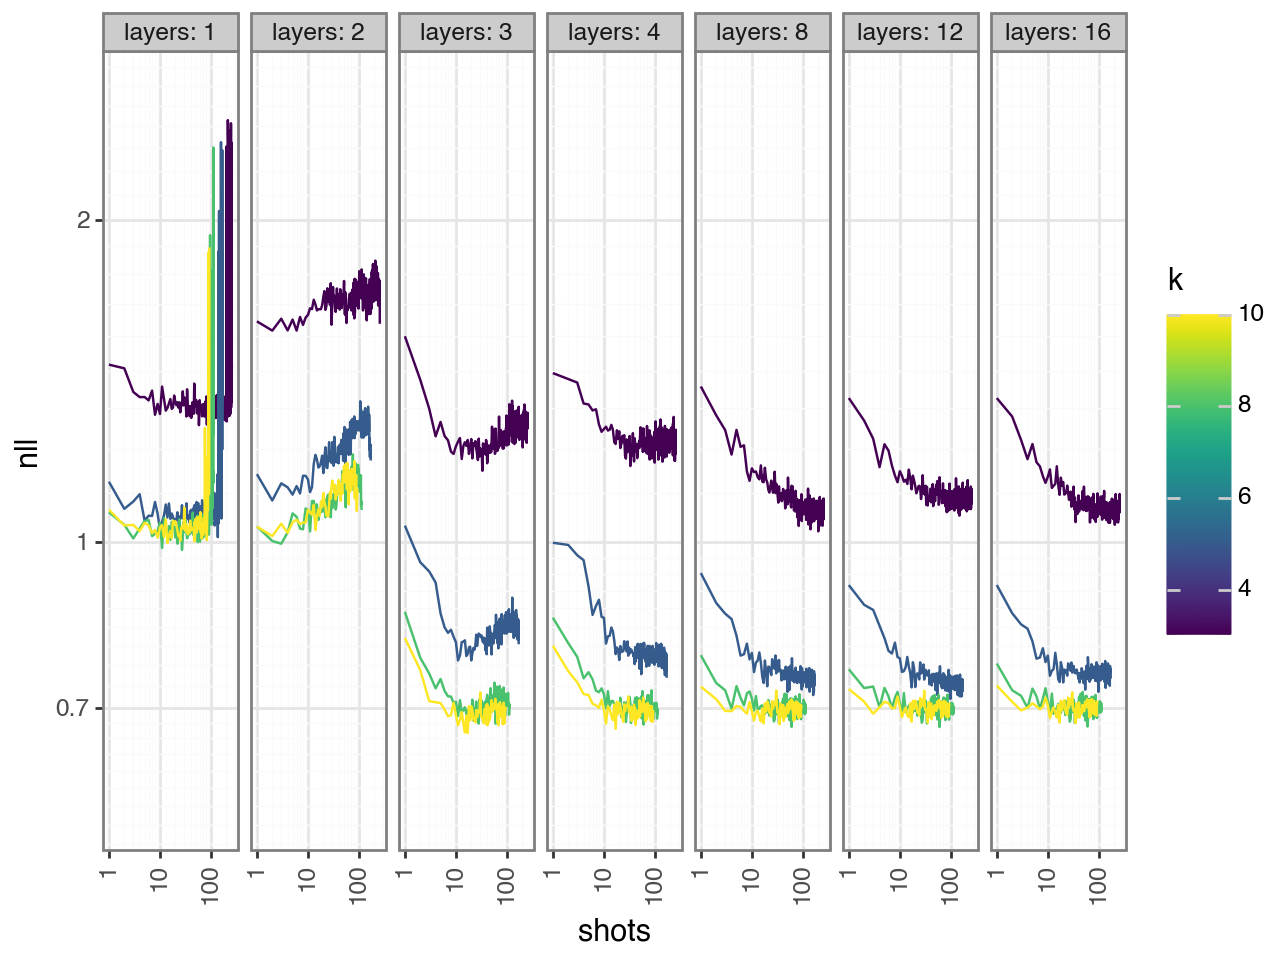

In [67]:
plot = (
    ggplot(df, aes(x="shots", y="nll", color="k", group="k")) +
    stat_summary(geom="line") + facet_grid("~layers", labeller="label_both") +
    theme_bw() + theme(axis_text_x=element_text(rotation=90)) + scale_x_log10() + scale_y_log10()
)
print(plot)

In [68]:
from analyse import compute_all_fits

In [102]:
def plot_fits(
    subset: pd.DataFrame,
    all_models: dict,
):
    est_nlls = []
    for hmm in subset['hmm'].unique():
        hmm_set = subset[subset['hmm'] == hmm]
        max_shots = hmm_set['shots'].max()
        for law in all_models:
            model = all_models[law]
            if isinstance(law, tuple):
                if law[1] != hmm: continue
                law = law[0]
            preds = model.estimate_nll(max_shots + 1, hmm)
            for i, pred in enumerate(preds):
                est_nlls.append({
                    'shots': i + 1,
                    'nll': pred.item(),
                    'prob': (-pred).exp().item(),
                    'law': law,
                    'hmm': hmm,
                })
    
    # plot
    est_nlls_df = pd.DataFrame(est_nlls)
    print(est_nlls_df)
    plot = (
        ggplot() + geom_line(subset, aes(x='shots', y='nll')) +
        geom_line(est_nlls_df, aes(x='shots', y='nll', color='law'), size=1) +
        facet_grid("~hmm", labeller="label_both") +
        theme_bw() + 
        theme(axis_text_x=element_text(rotation=90)) +
        scale_x_log10() + scale_y_log10()
    )
    print(plot)

layers=4, k=3
       shots       nll      prob             law  hmm
0          1  1.445829  0.235551  original (log)    0
1          2  1.445829  0.235551  original (log)    0
2          3  1.445829  0.235551  original (log)    0
3          4  1.445828  0.235551  original (log)    0
4          5  1.445828  0.235551  original (log)    0
...      ...       ...       ...             ...  ...
11515    252  1.181773  0.306735        logistic    4
11516    253  1.181656  0.306770        logistic    4
11517    254  1.181540  0.306806        logistic    4
11518    255  1.181425  0.306841        logistic    4
11519    256  1.181311  0.306876        logistic    4

[11520 rows x 5 columns]


/var/folders/ks/tsqyvj_n5bv55g97m0fc7tb40000gn/T/ipykernel_56062/4176490600.py:35: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


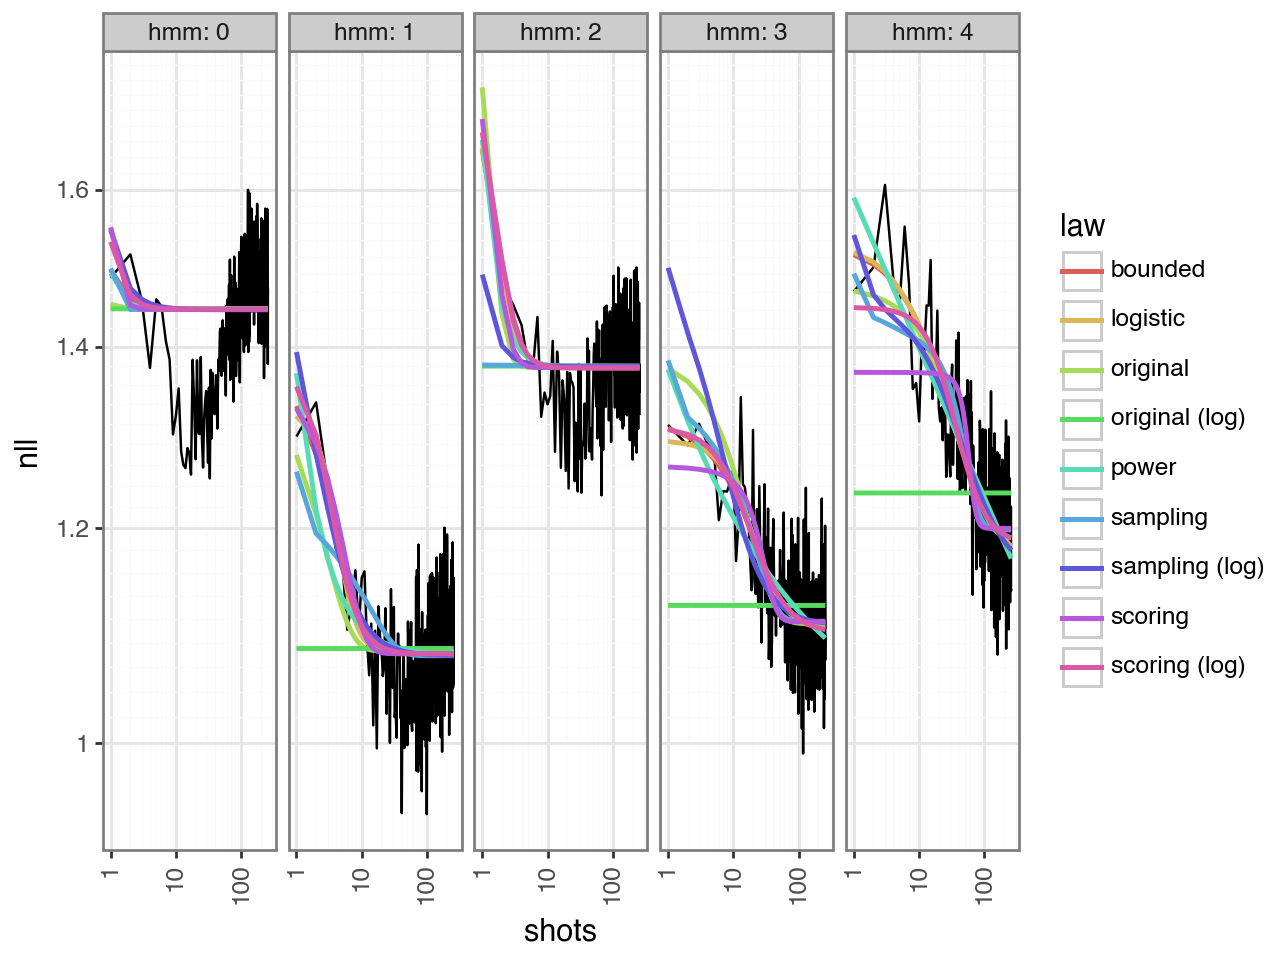


law
bayesian_original          0.043314
bayesian_original (log)    0.052783
bayesian_sampling          0.044048
bayesian_sampling (log)    0.043915
bayesian_scoring           0.043860
bayesian_scoring (log)     0.042957
bounded                    0.042748
logistic                   0.040838
power                      0.043461
Name: nrmse, dtype: float64
law
bayesian_original          0
bayesian_original (log)    0
bayesian_sampling          0
bayesian_sampling (log)    0
bayesian_scoring           0
bayesian_scoring (log)     0
bounded                    0
logistic                   1
power                      0
Name: nrmse, dtype: int64


KeyboardInterrupt: Interrupted by user

In [118]:
all_params = []
for layers in df["layers"].unique():
    if layers < 4:
        continue
    for k in df["k"].unique():
        print(f"layers={layers}, k={k}")
        subset = df[(df["layers"] == layers) & (df["k"] == k)]
        params, models = compute_all_fits(
            subset=subset, max_shots=1.0, quiet=True, patience=100, epochs=100,
            lr=5e-2, num_hmms=5, i=0, metadata={"layers": layers, "k": k},
            mode="lbfgs", loss_mode="mse"
        )
        # check number of nans in nrmse
        params = pd.DataFrame(params)
        all_params.append(params)
        plot_fits(subset, models)
        nrmse_by_law = params["nrmse"].groupby(params["law"]).mean()
        nans_by_law = params["nrmse"].isna().groupby(params["law"]).sum()
        print(nrmse_by_law)
        print(nans_by_law)
        input()

    hmm                      law      rmse     nrmse  log_rmse  log_nrmse  \
0     0  bayesian_original (log)  0.072992  0.050484  0.051349   0.198682   
1     0  bayesian_sampling (log)  0.073102  0.050560  0.051411   0.198981   
2     0   bayesian_scoring (log)  0.072992  0.050484  0.051348   0.198682   
3     0        bayesian_original  0.072991  0.050484  0.051348   0.198680   
4     0        bayesian_sampling  0.072994  0.050486  0.051355   0.198688   
5     0         bayesian_scoring  0.073140  0.050587  0.051421   0.199085   
6     0                    power  0.072937  0.050446  0.051309   0.198532   
7     0                  bounded  0.072900  0.050421  0.051281   0.198433   
8     0                 logistic       NaN       NaN       NaN        NaN   
9     1  bayesian_original (log)  0.054245  0.050058  0.049568   0.685966   
10    1  bayesian_sampling (log)  0.051432  0.047463  0.047571   0.650395   
11    1   bayesian_scoring (log)  0.053932  0.049770  0.049378   0.682020   

/var/folders/ks/tsqyvj_n5bv55g97m0fc7tb40000gn/T/ipykernel_56062/4011316992.py:33: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


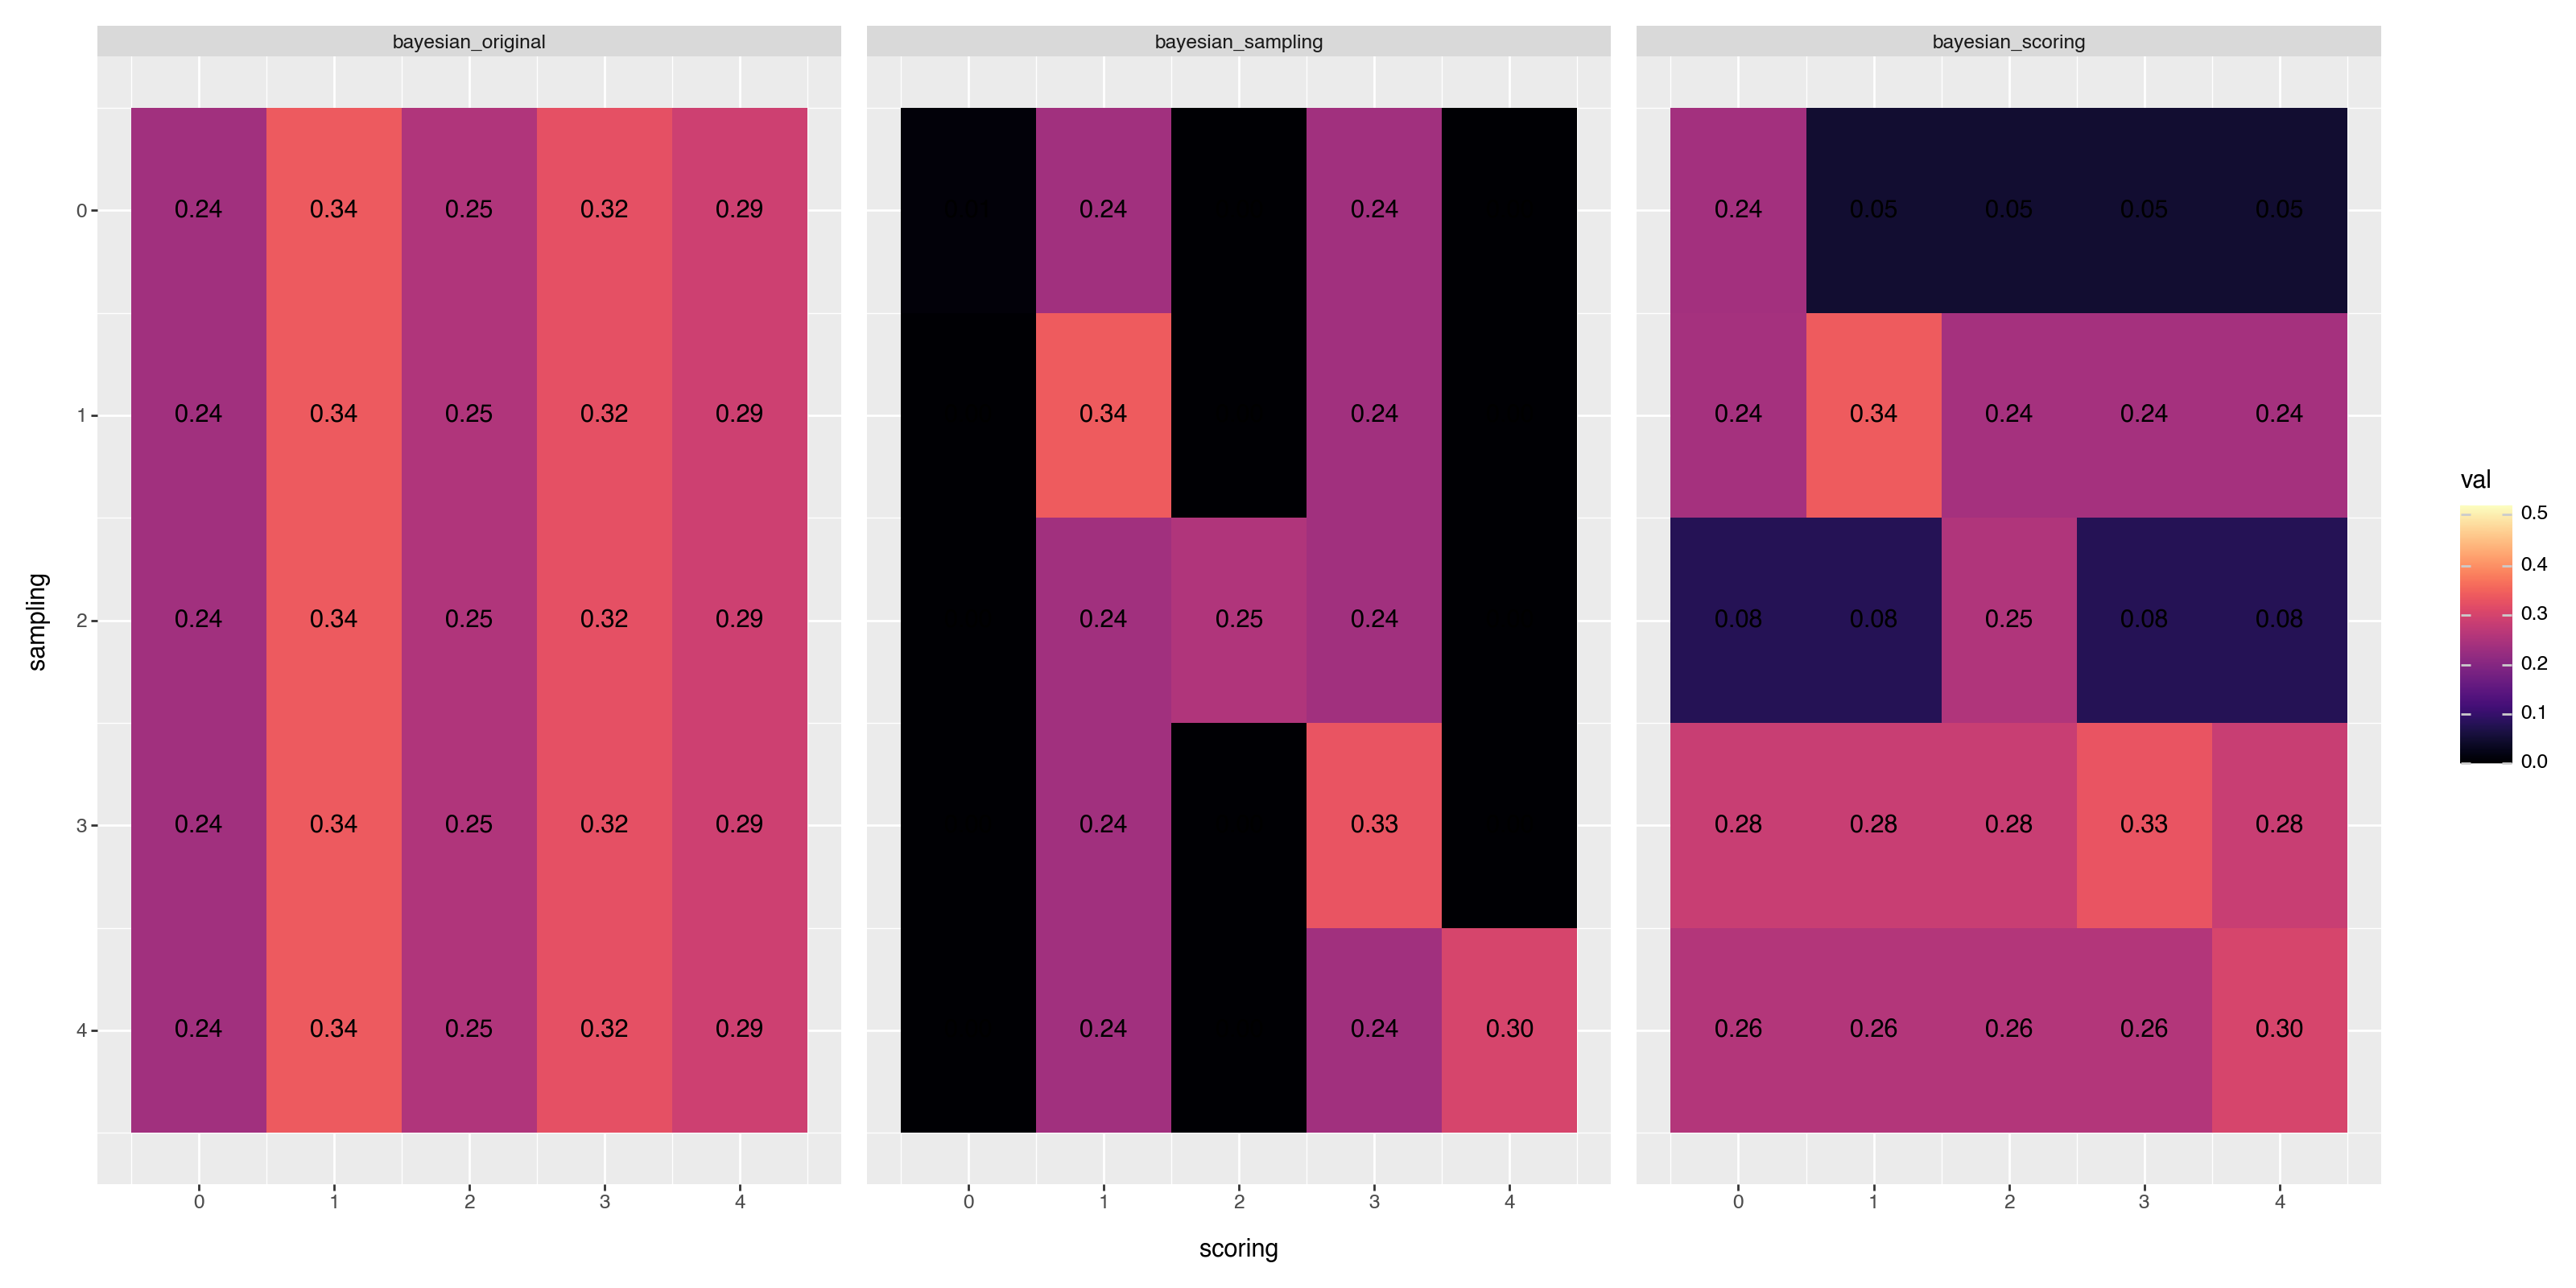

In [117]:
params_df = pd.concat(all_params)
# print(params_df)
layers = 4
k = 3
subset = params_df[(params_df["layers"] == layers) & (params_df["k"] == k)]
print(subset)

entries = []
for sampling_hmm in range(5):
    for scoring_hmm in range(5):
        # BO
        val = subset[(subset["law"] == "bayesian_original") & (subset["hmm"] == sampling_hmm)][f"P_{scoring_hmm}"].mean()
        entries.append({"law": "bayesian_original", "sampling": sampling_hmm, "scoring": scoring_hmm, "val": val})

        if sampling_hmm == scoring_hmm:
            val = subset[(subset["law"] == "bayesian_scoring") & (subset["hmm"] == sampling_hmm)][f"gammas"].mean()
            entries.append({"law": "bayesian_scoring", "sampling": sampling_hmm, "scoring": scoring_hmm, "val": val})
            val = subset[(subset["law"] == "bayesian_sampling") & (subset["hmm"] == sampling_hmm)][f"gammas"].mean()
            entries.append({"law": "bayesian_sampling", "sampling": sampling_hmm, "scoring": scoring_hmm, "val": val})
        else:
            val = subset[(subset["law"] == "bayesian_scoring") & (subset["hmm"] == sampling_hmm)][f"betas"].mean()
            entries.append({"law": "bayesian_scoring", "sampling": sampling_hmm, "scoring": scoring_hmm, "val": val})
            val = subset[(subset["law"] == "bayesian_sampling") & (subset["hmm"] == scoring_hmm)][f"betas"].mean()
            entries.append({"law": "bayesian_sampling", "sampling": sampling_hmm, "scoring": scoring_hmm, "val": val})

entries_df = pd.DataFrame(entries)
entries_df["val"] = entries_df["val"].map(lambda x: math.exp(x))
plot = (
    ggplot(entries_df, aes(x="scoring", y="sampling", fill="val", label="val")) + geom_tile() +
    scale_y_reverse() + facet_grid("~law") + geom_text(format_string="{:.2f}") +
    theme(figure_size=(16, 8)) + scale_fill_cmap(cmap_name="magma", limits=(0, 0.52))
)
print(plot)

layers=4, k=3
       shots       nll      prob             law  hmm
0          1  1.465806  0.230892  original (log)    0
1          2  1.465757  0.230903  original (log)    0
2          3  1.465729  0.230910  original (log)    0
3          4  1.465709  0.230914  original (log)    0
4          5  1.465693  0.230918  original (log)    0
...      ...       ...       ...             ...  ...
11515    252  1.178083  0.307868        logistic    4
11516    253  1.177893  0.307927        logistic    4
11517    254  1.177705  0.307985        logistic    4
11518    255  1.177517  0.308043        logistic    4
11519    256  1.177330  0.308100        logistic    4

[11520 rows x 5 columns]


/var/folders/ks/tsqyvj_n5bv55g97m0fc7tb40000gn/T/ipykernel_56062/4176490600.py:35: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


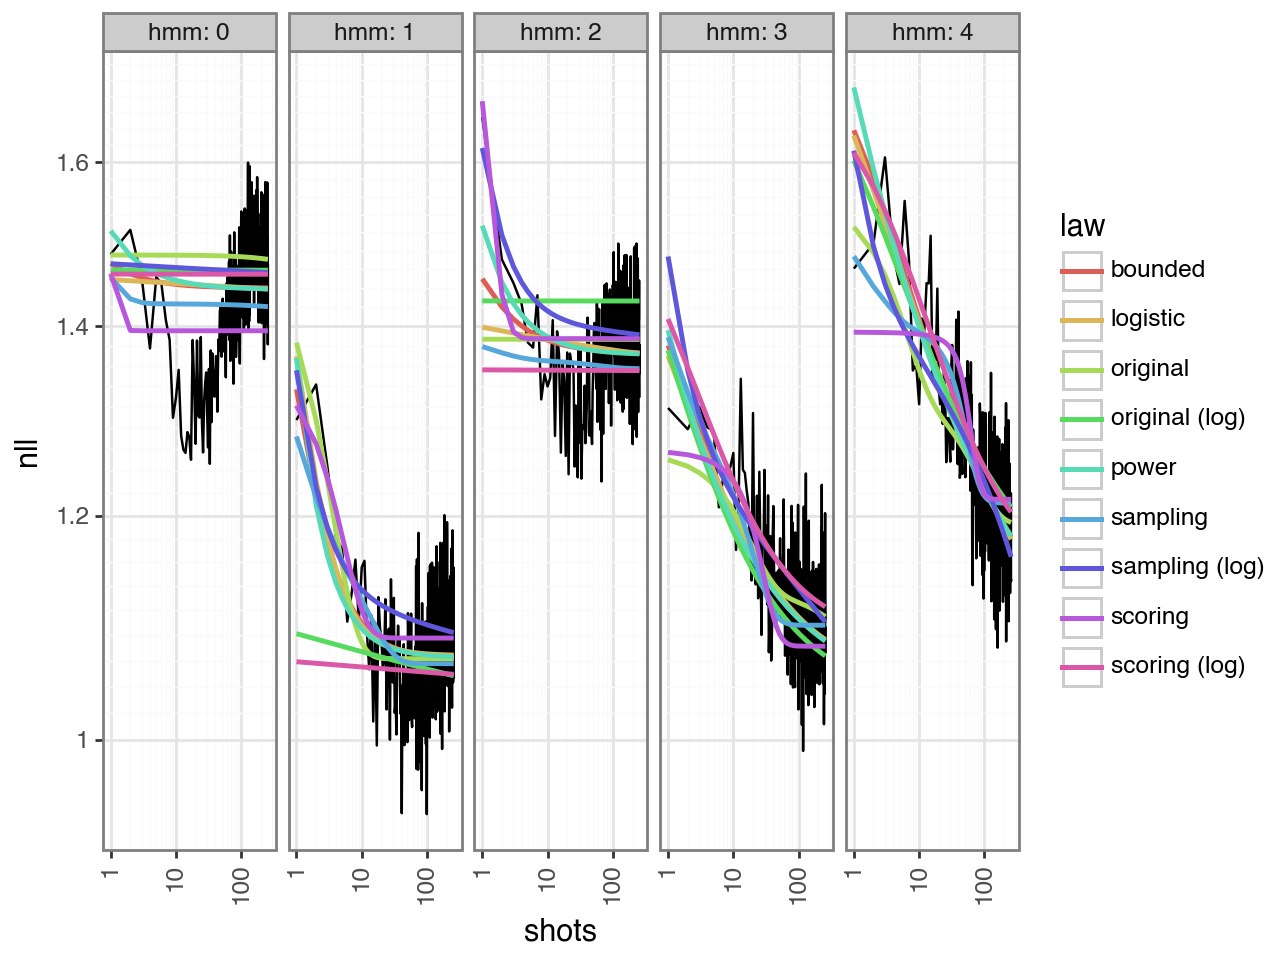


law
bayesian_original          0.045768
bayesian_original (log)    0.050927
bayesian_sampling          0.046023
bayesian_sampling (log)    0.046397
bayesian_scoring           0.047959
bayesian_scoring (log)     0.048182
bounded                    0.044317
logistic                   0.044486
power                      0.044714
Name: nrmse, dtype: float64
law
bayesian_original          0
bayesian_original (log)    0
bayesian_sampling          0
bayesian_sampling (log)    0
bayesian_scoring           0
bayesian_scoring (log)     0
bounded                    0
logistic                   0
power                      0
Name: nrmse, dtype: int64


KeyboardInterrupt: Interrupted by user

In [97]:
all_params = []
for layers in df["layers"].unique():
    if layers < 4:
        continue
    for k in df["k"].unique():
        print(f"layers={layers}, k={k}")
        subset = df[(df["layers"] == layers) & (df["k"] == k)]
        params, models = compute_all_fits(
            subset=subset, max_shots=1.0, quiet=True, patience=100, epochs=100,
            lr=5e-2, num_hmms=5, i=0, metadata={"layers": layers, "k": k},
            mode="adam", loss_mode="mse_prob"
        )
        # check number of nans in nrmse
        params = pd.DataFrame(params)
        all_params.append(params)
        plot_fits(subset, models)
        nrmse_by_law = params["nrmse"].groupby(params["law"]).mean()
        nans_by_law = params["nrmse"].isna().groupby(params["law"]).sum()
        print(nrmse_by_law)
        print(nans_by_law)
        input()